## Earth observation images time series interpolation

This notebook shows the application of the time series interpolation module for the interpolation of optical and radar satellite imagery time series. The methods are implemented as ufuncs for xarray objects. This example only operates in a small dataset, yet support for bigger areas of interest was considered with support of dask package.

First we use leaflet to let the user choose an area of interest to perform the interpolation of the dataset. We can also do this by reading polygons from a shapefile using GeoPandas.

In [2]:
import sys
import os
import pyproj

import numpy as np
import xarray as xr

from shapely import geometry
from ipyleaflet import Map
from ipyleaflet import DrawControl
from ipyleaflet.leaflet import TileLayer

sys.path.append('../b_Temporal_Stack')
import regionstack
import eotempstack
import xr_eotemp

In [2]:
%matplotlib inline

sat_url = "https://api.mapbox.com/styles/v1/asalazar/cjjjz8n1w56hx2snp8675oedp/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoiYXNhbGF6YXIiLCJhIjoiY2pqano3YngxMGNoMDNycXF2dDhqOTRkYiJ9.MecIVccMuRf5zhm4rk7qHA"

m = Map(center=(4.6767, -71.2653), zoom=5)
dc = DrawControl()
st = TileLayer(opacity=1.0, url=sat_url, zoom=0, max_zoom=25, attribution='<a href=’https://mapbox.com’>Mapbox</a>')

m.add_layer(st)
m.add_control(dc)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

POLYGON ((504765.1018872256 432173.3636618303, 504879.4585611887 432012.4302672958, 505298.6374944127 432447.8514645732, 505031.8509236951 432665.4805918207, 504765.1018872256 432173.3636618303))


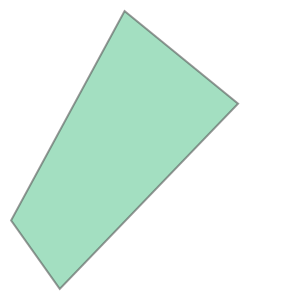

In [28]:
# Projection of the map
wgs84 = pyproj.Proj(init='epsg:4326')
# Projection of the dataset
wgs84_18N = pyproj.Proj(init='epsg:32618')
# Get and reproject geom coordinates
coords = [pyproj.transform(wgs84,wgs84_18N,x,y) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
# Make shapely polygon
polygon = geometry.polygon.Polygon(coords)
# Display polygon
print(polygon.wkt)
polygon

Now we get the data. Using the polygon bounds we can only load to memory the data in the smaller area of interest.

In [7]:
bounds = polygon.bounds

In [9]:
saldana = regionstack.regionStack('Saldana', attrs=['S2','LC08'])

S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana/pre/
Reading 3 S2 stack files
Reading 9 hLC08 stack files
Harmonized Landsat-8 dataset was read


In [10]:
s2_sub = saldana.S2.sel(x=slice(bounds[0],bounds[2]), y=slice(bounds[3],bounds[1]))
l8_sub = saldana.LC08.sel(x=slice(bounds[0],bounds[2]), y=slice(bounds[3],bounds[1]))

In [4]:
saldana.LC08['mask'] = saldana.LC08.mask.astype(bool)

In [16]:
#Now we use xarray concatenation method to build a complete optical dataset using Sentinel-2 and
#the Harmonized Landsat 8 on the time dimension.

optical = xr.concat([s2_sub, l8_sub], dim='time')

optical

<xarray.Dataset>
Dimensions:  (time: 23, x: 189, y: 178)
Coordinates:
  * y        (y) float64 4.333e+05 4.333e+05 4.333e+05 4.333e+05 4.333e+05 ...
  * x        (x) float64 5.046e+05 5.047e+05 5.047e+05 5.047e+05 5.047e+05 ...
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
    mask     (time, y, x) int8 dask.array<shape=(23, 178, 189), chunksize=(8, 178, 189)>
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(23, 178, 189), chunksize=(8, 178, 189)>
    green    (time, y, x) uint16 dask.array<shape=(23, 178, 189), chunksize=(8, 178, 189)>
    red      (time, y, x) uint16 dask.array<shape=(23, 178, 189), chunksize=(8, 178, 189)>
    nir      (time, y, x) uint16 dask.array<shape=(23, 178, 189), chunksize=(8, 178, 189)>
    swir1    (time, y, x) uint16 dask.array<shape=(23, 178, 189), chunksize=(8, 178, 189)>
    swir2    (time, y, x) uint16 dask.array<shape=(23, 178, 189), chunksize=(8, 178, 189)>
    NDVI     (time, y, x) float32 dask.array<shap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


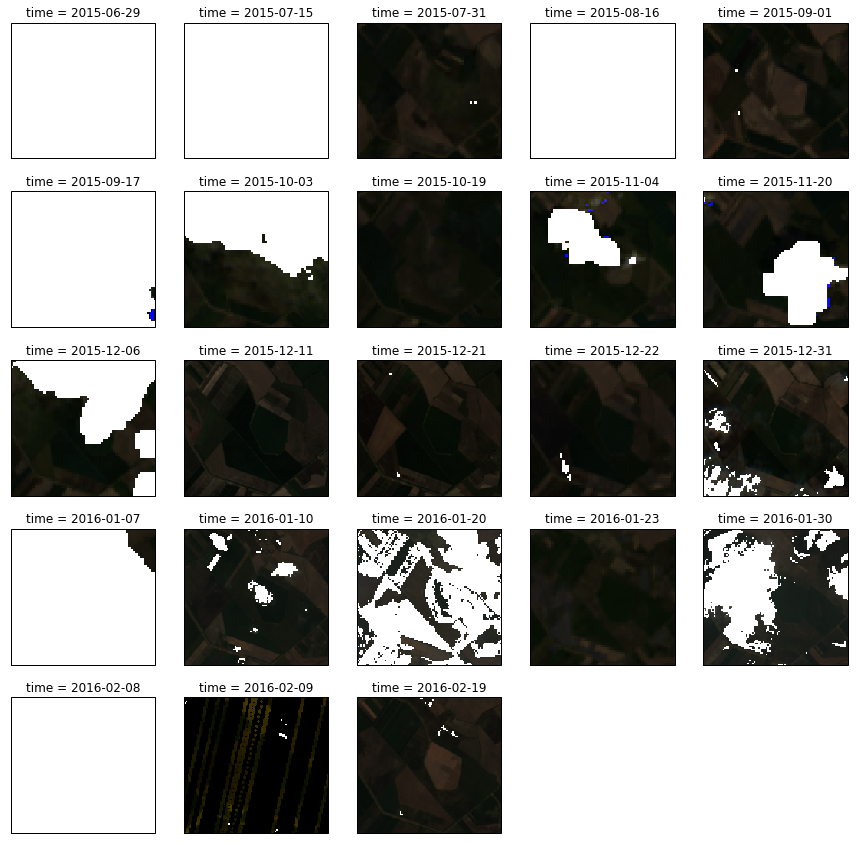

In [19]:
#We can now visually inspect the dataset using the plot_RGB method
import xr_eotemp

optical.where(optical.mask).eotemp.plot_RGB()

## Interpolation module

Now we import the interpolation module. The default behaviour of the methods is to write the interpolated datasets to disk as netcdf files.

In [21]:
sys.path.append('../c_Class_Models')
import interpolatets

In [23]:
##Call dataset interpolation method

# Directory to write file, location must already exist
write_location = os.environ['WIN_SVR_DATA']+'Saldana/interpolation_test/'
# Bands to be interpolated
bands = ['NDVI', 'LSWI']
# Date of analysis, allows multiple dates
doa = [np.datetime64('2015-12-21')]

interpolatets.interpolate_dataset(optical, write_location, bands=bands, date_of_analysis=doa)

Date of analysis is [numpy.datetime64('2015-12-21')], interpolating:
['2015-07-14' '2015-07-30' '2015-08-15' '2015-08-31' '2015-09-16'
 '2015-10-02' '2015-10-18' '2015-11-03' '2015-11-19' '2015-12-05'
 '2015-12-21' '2016-01-06']
Writing NDVI band to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana/interpolation_test/NDVI.nc
Done!
Writing LSWI band to /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana/interpolation_test/LSWI.nc
Done!


In [4]:
#Now we can read the interpolated dataset
int_ndvi = xr.open_dataset(write_location+'NDVI.nc')
int_lswi = xr.open_dataset(write_location+'LSWI.nc')

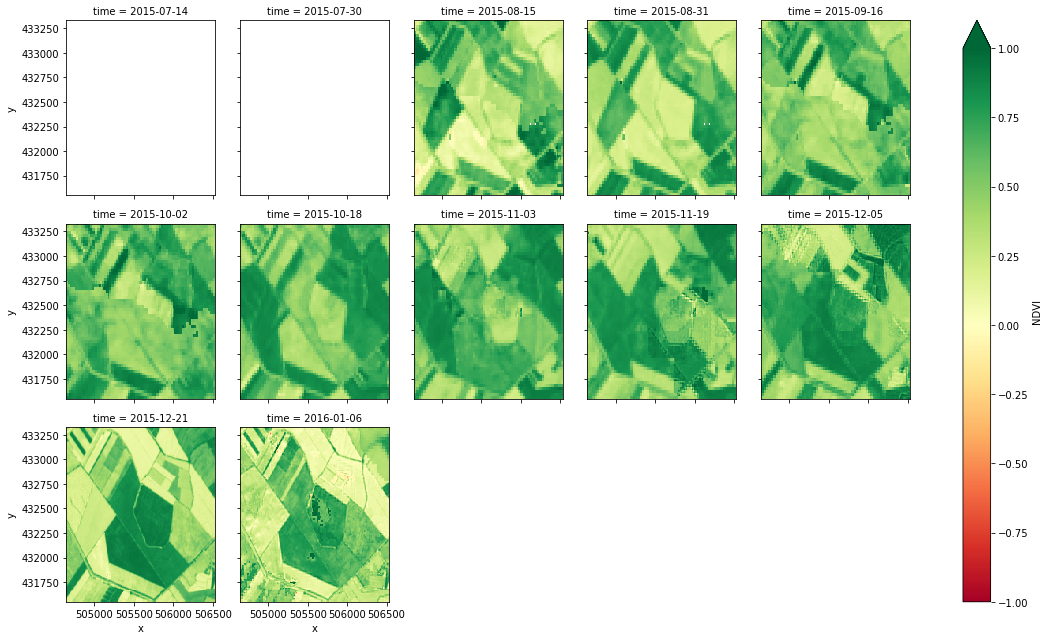

In [27]:
int_ndvi.NDVI.plot(col='time', col_wrap=5, cmap='RdYlGn', vmin=-1, vmax=1)

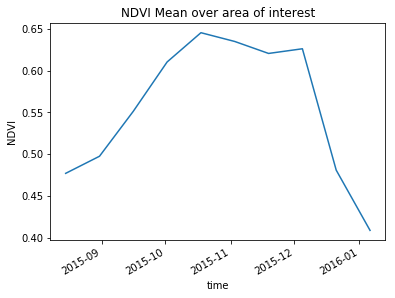

In [12]:
int_ndvi.NDVI.mean(dim=['x','y']).plot()
plt.title('NDVI Mean over area of interest')
plt.show()

### Inspect specific field in the area of interest

We now visualize the time series of a specific field in the region of the interpolated dataset. For this, draw a polygon with the field's shape in the map, then execute the the following cell. Alternatively, we can read a polygon from a shapefile.

In [29]:
# Projection of the map
wgs84 = pyproj.Proj(init='epsg:4326')
# Projection of the dataset
wgs84_18N = pyproj.Proj(init='epsg:32618')
# Get and reproject geom coordinates
coords = [pyproj.transform(wgs84,wgs84_18N,x,y) for (x,y) in dc.last_draw['geometry']['coordinates'][0]]
# Make shapely polygon
polygon2 = geometry.polygon.Polygon(coords)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def mask_field_dataset(dataset, band, polygon):
    """
    Plot time-series of a band for points within a polygon of interest
    
    Args:
        dataset (xarray.Dataset): dataset with time series data
        band (str): band to plot
        polygon (shapely.geometry.polygon.Polygon): area of interest
    """
    
    bb = polygon.bounds
    
    try:
        mask = dataset.mask.sel(x=slice(bb[0],bb[2]), y=slice(bb[3],bb[1]))
        ds = dataset.where(mask).sel(x=slice(bb[0],bb[2]), y=slice(bb[3],bb[1]))
    except:
        ds = dataset.sel(x=slice(bb[0],bb[2]), y=slice(bb[3],bb[1]))
    
    ds_copy = ds.copy(deep=True)
    ds_copy.coords['pmask'] = (('y','x','time'), np.zeros((ds_copy.y.values.shape[0],
                                                           ds_copy.x.values.shape[0],
                                                           ds_copy.time.values.shape[0])))    
    
    for x in ds.x.values:
        for y in ds.y.values:
            if geometry.point.Point(x,y).within(polygon):
                #array.sel(x=x,y=y).plot.line(marker='o')
                length = dataset.sel(x=x,y=y).time.values.shape
                ds_copy['pmask'].loc[dict(x=x,y=y)] = np.repeat(1, length[0])
            else:
                pass
    
    return ds_copy


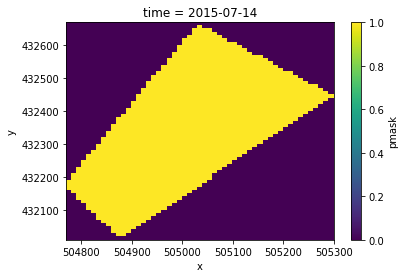

In [39]:
field_ndvi = mask_field_dataset(int_ndvi, 'NDVI', polygon2)
field_ndvi.pmask.isel(time=0).plot()

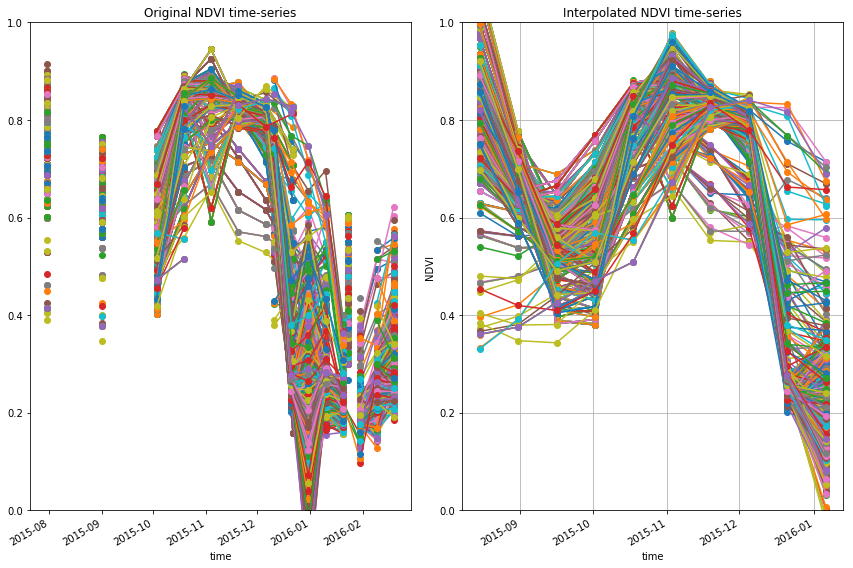

In [54]:
#Now we visualize the orignal and interpolated datasets for this particular polygon

fig, ax = plt.subplots(ncols=2, figsize=(12,8))

ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

orig_masked = optical.NDVI.where(optical.mask).load()

for x in field_ndvi.x.values:
    for y in field_ndvi.y.values:
        if geometry.point.Point(x,y).within(polygon):
            orig_masked.sel(x=x,y=y).plot.line(marker='o', ax=ax[0])
            field_ndvi.NDVI.sel(x=x, y=y).plot.line(marker='o', ax=ax[1])
        else:
            pass

ax[0].set_title('Original NDVI time-series')
ax[1].set_title('Interpolated NDVI time-series')

plt.tight_layout()
plt.grid()
plt.show()

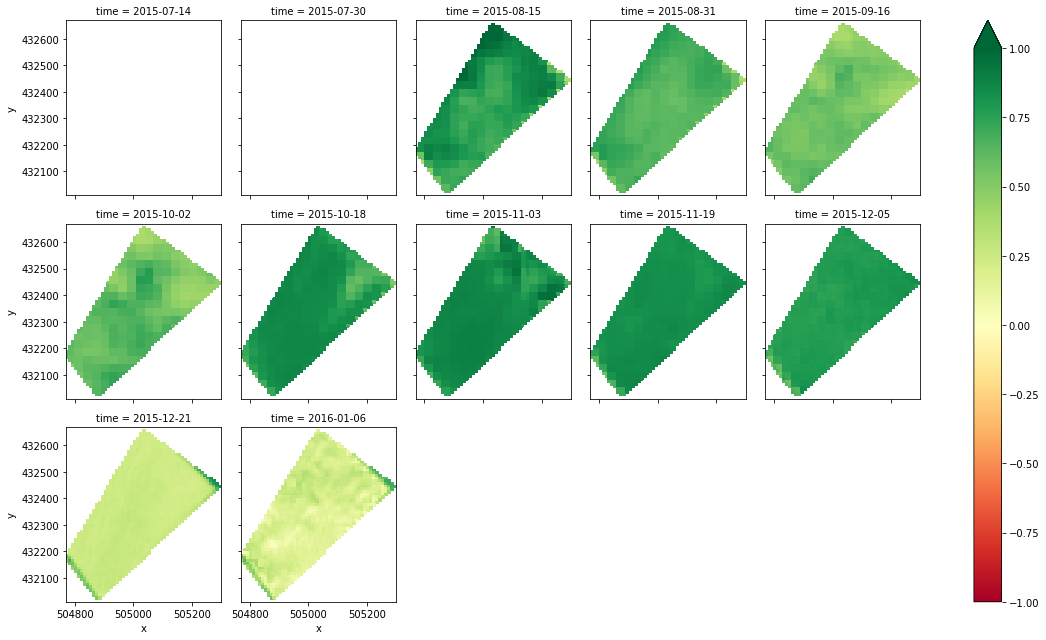

In [48]:
field_ndvi.NDVI.where(field_ndvi.pmask).plot(col='time', col_wrap=5, cmap='RdYlGn', vmin=-1, vmax=1)